#### Dangerous Goods Classification

Given a set of chemical parameters, I want to bo build a model using Neural Networks that classifies chemical products into Dangerous v Safe goods. This enables us to automatically identify the kind of equipment needed to transport the products from our warehouse to the customer. 
Through this automatic classification, we want to give our operations teams more efficiency in their day to day work, thereby freeing them for more strategic work

# Synthetic Dangerous Goods Dataset

This dataset contains 10,000+ synthetic samples designed for ML experiments in **logistics & hazardous goods classification**.

## Features
- flash_point_c: Flash point (°C)
- boiling_point_c: Boiling point (°C)
- ph: Acidity/alkalinity (0–14)
- vapor_pressure_kpa: Vapor pressure (kPa)
- toxicity_score: Arbitrary toxicity index (0–100)
- oxidizer_content_pct: % oxidizers
- flammable_content_pct: % flammable material
- corrosive_content_pct: % corrosives
- packaging_group: UN packaging group (I = high danger, II = medium, III = low)
- dangerous_good: Target (1 = dangerous, 0 = not dangerous)

## Labeling rules
A product is dangerous if:
- flash_point_c < 60
- OR toxicity_score > 70
- OR ph < 2 or ph > 12
- OR oxidizer_content_pct > 20
- OR flammable_content_pct > 40
- OR corrosive_content_pct > 25
- OR packaging_group == I


In [180]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input

In [ ]:
#assigning data source to data variable
data = r'/dangerous_goods_data/dangerous_goods_dataset.csv'

In [182]:
#loading data to dataframe
df = pd.read_csv(data)

In [183]:
# assessing the number of rows and columns of the dataset
df.shape

(10000, 10)

In [184]:
# getting dataframe info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   flash_point_c          10000 non-null  float64
 1   boiling_point_c        10000 non-null  float64
 2   ph                     10000 non-null  float64
 3   vapor_pressure_kpa     10000 non-null  float64
 4   toxicity_score         10000 non-null  float64
 5   oxidizer_content_pct   10000 non-null  float64
 6   flammable_content_pct  10000 non-null  float64
 7   corrosive_content_pct  10000 non-null  float64
 8   packaging_group        10000 non-null  object 
 9   dangerous_good         10000 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 781.4+ KB


no missing data identified

In [185]:
# statistical description of the data 

df.describe()

flash_point_c  boiling_point_c            ph  vapor_pressure_kpa  \
count   10000.000000     10000.000000  10000.000000        10000.000000   
mean       59.957280       150.770481      6.934258            3.691425   
std        20.069248        49.779576      4.016917            3.504377   
min       -18.448005        20.000000      0.000078            0.076346   
25%        46.548189       116.899455      3.432586            1.539985   
50%        59.948100       150.792336      6.953243            2.676979   
75%        73.421618       184.693243     10.349843            4.651952   
max       138.524754       373.954213     13.997051           53.638478   

       toxicity_score  oxidizer_content_pct  flammable_content_pct  \
count    10000.000000          10000.000000           10000.000000   
mean        50.172422             20.109477              28.601170   
std         14.934351             11.965856              15.861486   
min          0.000000              0.117990               0.216250   
25%         40.126090             10.870767              16.144155   
50%         50.172894             18.295576              26.716552   
75%         60.377562             27.377486              39.060787   
max        100.000000             74.571365              88.730125   

       corrosive_content_pct  dangerous_good  
count           10000.000000    10000.000000  
mean               15.702925        0.909600  
std                11.373187        0.286768  
min                 0.029346        0.000000  
25%                 6.913179        1.000000  
50%                13.147318        1.000000  
75%                21.884258        1.000000  
max                76.902296        1.000000

In [186]:
#looking at the first 20 rows

df.head(20)

flash_point_c  boiling_point_c         ph  vapor_pressure_kpa  \
0       69.934283       116.075263   0.779329            0.303269   
1       57.234714       134.725027  13.800746           15.192768   
2       72.953771       120.130947  11.200259            2.160102   
3       90.460597       155.520902  12.163327            2.335780   
4       55.316933       209.858927   9.720120            2.590853   
5       55.317261       111.447892   2.604700            3.699377   
6       91.584256       200.041025   0.434398            2.717710   
7       75.348695       110.916396  12.105193            2.443139   
8       50.610512       107.618639   5.548629            7.745675   
9       70.851201       190.929731   3.694108            4.273687   
10      50.731646       196.096819   7.863421            1.262327   
11      50.685405       192.570497   5.892579            4.916216   
12      64.839245        84.210130   9.123324            4.134166   
13      21.734395       126.702451   6.773105            1.757304   
14      25.501643       191.149430   9.761264            5.122849   
15      48.754249       152.077092  11.947926            2.396338   
16      39.743378        96.315358   2.737798            2.276550   
17      66.284947       172.915897   4.612060            2.227477   
18      41.839518       114.259637   6.115418            0.389655   
19      31.753926       239.726242  13.468818            1.783612   

    toxicity_score  oxidizer_content_pct  flammable_content_pct  \
0        60.027178             25.848129              38.832753   
1        62.245355              5.842114              28.443824   
2        38.807154             12.131286              25.717801   
3        33.466539             10.439709              39.382189   
4        41.194221             14.588970              28.723769   
5        67.863065              8.285501              31.598228   
6        24.356665             43.839891              74.579552   
7        31.760495             37.232567              21.212226   
8        43.118458              7.347056              18.799865   
9        35.364932             34.010542              32.579359   
10       49.374909             32.140301              50.176427   
11       71.217889              7.906098              40.739653   
12       31.942723             23.220201              37.194217   
13       47.804507             23.844969              36.640791   
14       49.876235             15.950441               6.352825   
15       44.981206              5.370540               5.736896   
16       26.323625             19.838221              29.801383   
17       40.432617             15.531501              14.065545   
18       40.477455             23.043432              26.912993   
19       59.502559             33.633228               5.340465   

    corrosive_content_pct packaging_group  dangerous_good  
0                1.559821             III               1  
1                4.737099              II               1  
2               32.298468               I               1  
3                5.158468              II               1  
4               13.220945             III               1  
5                4.999346              II               1  
6               43.267140              II               1  
7                6.406051             III               1  
8                5.028728             III               1  
9                6.677226             III               1  
10               9.747157             III               1  
11               8.176064               I               1  
12              10.581692              II               1  
13              19.786176              II               1  
14              14.451589             III               1  
15              18.748010              II               1  
16              12.914506              II               1  
17              13.725883              II               0  
18    

In [187]:
# looking at the last 20 rows

df.tail(20)

flash_point_c  boiling_point_c         ph  vapor_pressure_kpa  \
9980      51.084094       198.129599  11.904679            2.337159   
9981      49.925553       175.629976   1.873191            2.482048   
9982      70.518746       112.344421   6.377120            1.416043   
9983      64.877819       153.805121  13.259140            6.531996   
9984      36.140533       156.256650  10.809170            5.594911   
9985      52.145475       104.042067   1.637445            5.111372   
9986      52.570760        94.768751   7.035003            2.972701   
9987      24.480355       115.963920  12.913328            0.756647   
9988      40.381065       251.829118   6.160543            6.483989   
9989      44.583727       129.362795  11.723847            2.845856   
9990      88.672500       211.643340   6.941812            2.123630   
9991      63.829014       126.566975   1.495363            3.891393   
9992      73.243375       194.441941   2.069969            3.252265   
9993      30.027290       195.124583   0.653461            1.155625   
9994      83.884290       197.629525   2.734406            2.102993   
9995      86.022041       169.391367  12.510597            0.592577   
9996      20.033101       218.868329   9.102773            2.911945   
9997      45.893666       168.917698  10.343997            7.878222   
9998      69.915311       235.676486   8.703260            0.646300   
9999      72.887769        69.004010   5.411550            3.012898   

      toxicity_score  oxidizer_content_pct  flammable_content_pct  \
9980       41.405703              8.790299              34.150130   
9981       37.503647             19.120029              14.364790   
9982       37.894859             26.552220               9.503943   
9983       47.975928             33.030595              67.084583   
9984       42.626471             35.222705              23.577595   
9985       36.015975              9.987505              46.308696   
9986       77.070716             22.196410              52.732496   
9987       56.869325             11.751345              13.978179   
9988       52.377241              4.058671               8.554347   
9989       49.001819             17.015847              18.402211   
9990       59.984220             38.589307               7.342357   
9991       57.977352             26.298898              15.562832   
9992       34.485813             11.159938              20.008983   
9993       27.015948             10.399282              14.918065   
9994       15.888731             14.460619              11.488896   
9995       76.878967             21.055248              36.268845   
9996       43.320351             16.134886              32.786473   
9997       58.880893             24.697154              30.467244   
9998       53.030919              7.117966              20.829480   
9999       63.688381             29.324422              23.404356   

      corrosive_content_pct packaging_group  dangerous_good  
9980              24.261756               I               1  
9981              10.382753             III               1  
9982              13.116830             III               1  
9983               5.775578              II               1  
9984               6.643304              II               1  
9985              10.294733             III               1  
9986               8.139710              II               1  
9987              11.164931              II               1  
9988               5.708187              II               1  
9989               6.086753             III               1  
9990               8.821930               I               1  
9991               9.747524             III               1  
9992               2.713529              II               0  
9993               5.282230             III               1  
9994              19.328777             III               0  
9995               3.325585             III               1  
9996      

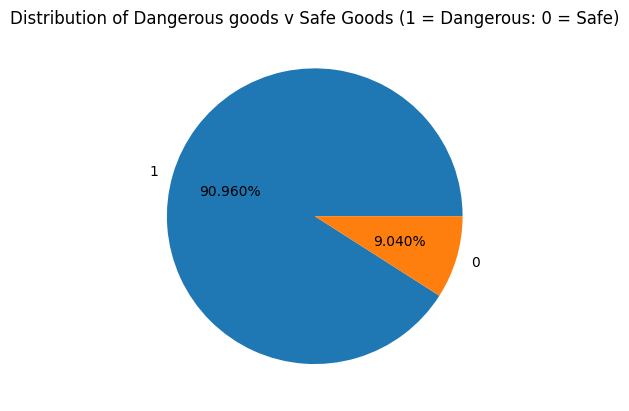

In [188]:
#distribution of goods type

dist = df["dangerous_good"].value_counts()
labels = df["dangerous_good"].unique()

plt.pie(x=dist.values, labels= labels, autopct='%1.3f%%')
plt.title("Distribution of Dangerous goods v Safe Goods (1 = Dangerous: 0 = Safe)")
plt.show()

Given the disproportionate amount of dangerous goods in the data, I would stratify the data to ensure the distribution is maintained when splitting the data between training and test sets

#### Assessing the distribution of the features

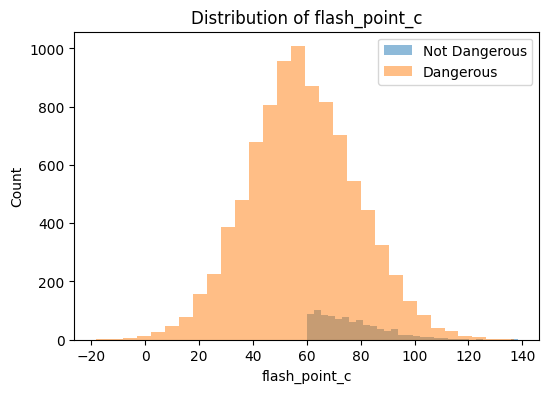

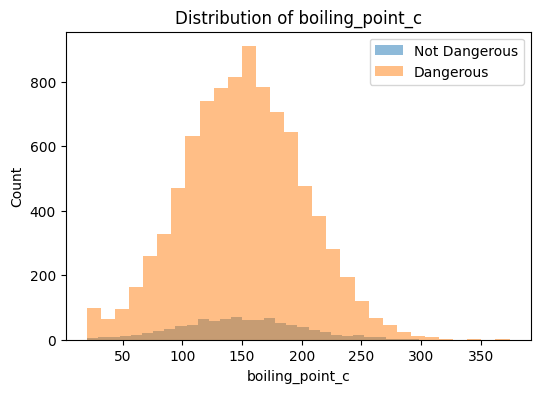

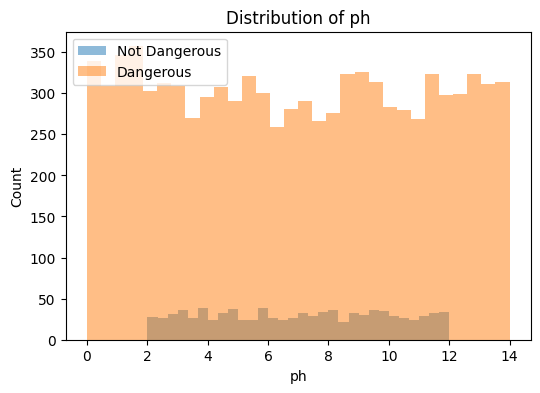

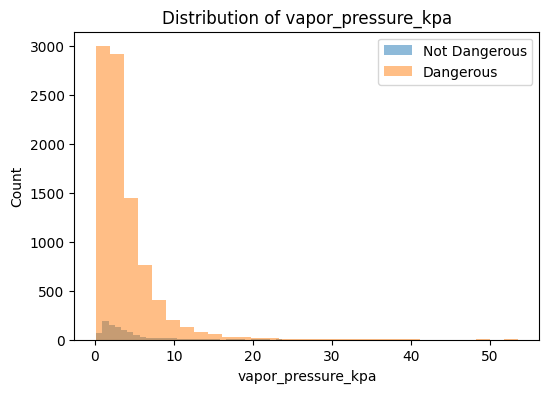

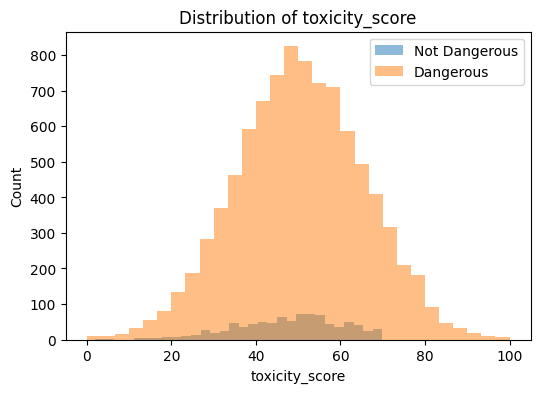

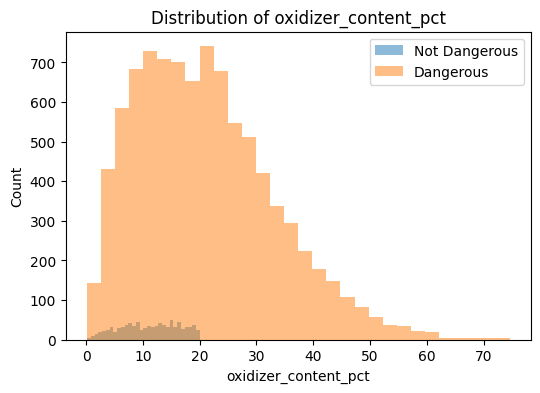

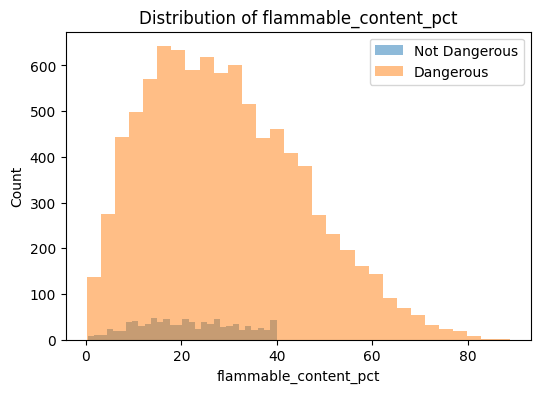

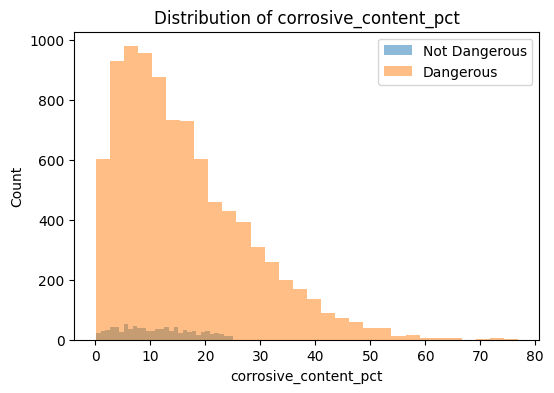

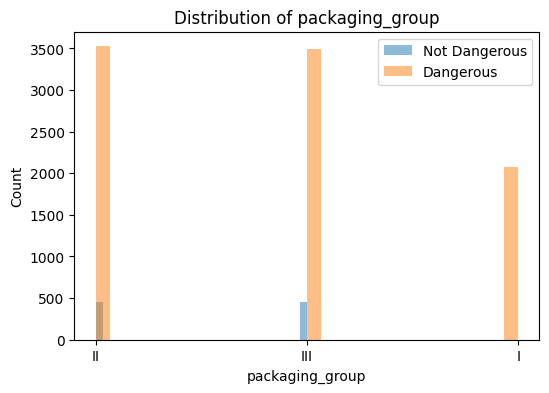

In [189]:
columns = df.columns

for col in columns:
    if col != "dangerous_good":
        plt.figure(figsize=(6,4))
        plt.hist(df[df["dangerous_good"] == 0][col], bins=30, alpha=0.5, label="Not Dangerous")
        plt.hist(df[df["dangerous_good"] == 1][col], bins=30, alpha=0.5, label="Dangerous")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend()
        plt.show()


In [190]:
cols = [c for c in df.columns if c not in ["dangerous_good", "packaging_group"]]
for i, col in enumerate(cols):
    for y in cols[i+1:]:
        fig = px.scatter(data_frame=df,
                        x=col,
                        y=y,
                        color="dangerous_good",
                        title=f"{col} vs {y}"
        )
        fig.show()

    

looking at the scatterplots I can tell it is hard to see clear cut separtion between Dangerous and safe goods in some cases. However, there is a clear boundary as well. the challange is to build a model that does not try to capture all the noise

In [191]:
cols = [c for c in df.columns if c not in ["packaging_type", "dangerous_good"]]

for col in cols:
    fig1 = px.box(df, y=col, color="dangerous_good", title = f"{col} box plots")
    fig1.show()

#### Feature scaling

In [192]:
cols = [c for c in df.columns if c != 'dangerous_good'] # excluding dg column
float_types = df[cols].select_dtypes(include="float") #selecting float-type columns
obj_types = df[cols].select_dtypes(include="object") # selecting object type columns

Scaling the float-type columns using z score

In [193]:
scaler = StandardScaler(with_std=True)
for col in float_types.columns:
    df[col] = scaler.fit_transform(df[[col]])

Encoding Object Type columns with Labels

In [194]:
label = LabelEncoder()
for col in obj_types.columns:
    df[col] = label.fit_transform(df[[col]])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [195]:
df.head(20)

flash_point_c  boiling_point_c        ph  vapor_pressure_kpa  \
0        0.497154        -0.697012 -1.532328           -0.966884   
1       -0.135665        -0.322346  1.709478            3.282157   
2        0.647615        -0.615535  1.062062           -0.436996   
3        1.519979         0.095434  1.301827           -0.386863   
4       -0.231228         1.187061  0.693567           -0.314072   
5       -0.231212        -0.789974 -1.077885            0.002269   
6        1.575971         0.989824 -1.618202           -0.277871   
7        0.766954        -0.800651  1.287354           -0.356225   
8       -0.465749        -0.866902 -0.344966            1.156968   
9        0.542844         0.806782 -0.806666            0.166161   
10      -0.459713         0.910586  0.231324           -0.693196   
11      -0.462017         0.839744 -0.259336            0.349521   
12       0.243268        -1.337168  0.544989            0.126346   
13      -1.904645        -0.483516 -0.040121           -0.551943   
14      -1.716923         0.811195  0.703810            0.408488   
15      -0.558247         0.026249  1.248200           -0.369581   
16      -1.007258        -1.093980 -1.044749           -0.403765   
17       0.315307         0.444892 -0.578133           -0.417769   
18      -0.902808        -0.733487 -0.203858           -0.942232   
19      -1.405372         1.787083  1.626841           -0.544436   

    toxicity_score  oxidizer_content_pct  flammable_content_pct  \
0         0.659905              0.479610               0.645091   
1         0.808441             -1.192399              -0.009921   
2        -0.761053             -0.666780              -0.181793   
3        -1.118677             -0.808154               0.679732   
4        -0.601208             -0.461378               0.007730   
5         1.184620             -0.988192               0.188961   
6        -1.728702              1.983277               2.898889   
7        -1.232919              1.431067              -0.465865   
8        -0.472355             -1.066623              -0.617962   
9        -0.991555              1.161786               0.250821   
10       -0.053404              1.005480               1.360297   
11        1.409269             -1.019901               0.765319   
12       -1.220717              0.259980               0.541783   
13       -0.158563              0.312195               0.506890   
14       -0.019834             -0.347593              -1.402735   
15       -0.347620             -1.231811              -1.441568   
16       -1.596989             -0.022670               0.075672   
17       -0.652207             -0.382606              -0.916456   
18       -0.649205              0.245206              -0.106438   
19        0.624775              1.130252              -1.466563   

    corrosive_content_pct  packaging_group  dangerous_good  
0               -1.243610                2               1  
1               -0.964231                1               1  
2                1.459254                0               1  
3               -0.927179                1               1  
4               -0.218242                2               1  
5               -0.941171                1               1  
6                2.423735                1               1  
7               -0.817479                2               1  
8               -0.938587                2               1  
9               -0.793634                2               1  
10              -0.523694                2               1  
11              -0.661841                0               1  
12              -0.450313                1               1  
13               0.359042                1               1  
14              -0.110031                2               1  
15               0.267756                1               1  
16              -0.245187                1               1  
17              -0.173842                1               0  
18      

#### Splitting the Data

In [196]:
X_data = df.drop("dangerous_good", axis=1) # x= input featues
y_data = df["dangerous_good"] # y = label

In [197]:
#splitting the data into training and test sets. Reserving 20% of the data for testing, stratifying y_data to ensure there is a balance in the split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, stratify=y_data, random_state=1)

In [198]:
#building  Neural Network model using forward prop 
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9097 - loss: 0.2869 - val_accuracy: 0.9094 - val_loss: 0.2080
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9097 - loss: 0.1698 - val_accuracy: 0.9094 - val_loss: 0.1663
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9286 - loss: 0.1440 - val_accuracy: 0.9300 - val_loss: 0.1532
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.9448 - loss: 0.1303 - val_accuracy: 0.9388 - val_loss: 0.1403
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.9491 - loss: 0.1178 - val_accuracy: 0.9519 - val_loss: 0.1278
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.9531 - loss: 0.1066 - val_accuracy: 0.9481 - val_loss: 0.1272
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.9569 - loss: 0.0987 - val_accuracy: 0.9569 - val_loss: 0.1109
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.9613 - loss: 0.0890 - va

In [199]:
#determining the probability of outcomes for the lables
y_hat_prob = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step


In [200]:
# classifying probabilities of >= 0.5 as dangerous
y_hat = (y_hat_prob >= 0.5).astype(int) 


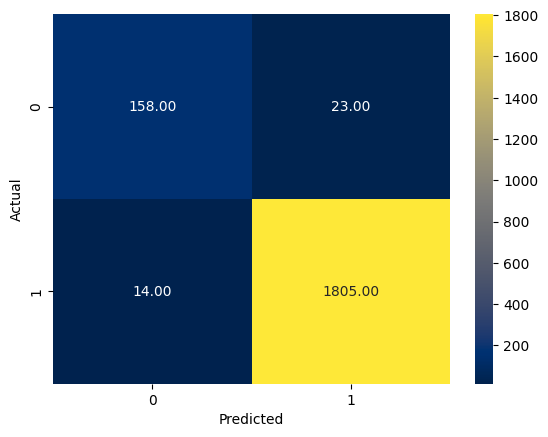

In [201]:
#plotting a confusion matrix
conf_m = confusion_matrix(y_test,y_hat)

sns.heatmap(conf_m, annot=True, fmt = ".2f", cmap="cividis")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [204]:
print(classification_report(y_hat, y_test))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       172
           1       0.99      0.99      0.99      1828

    accuracy                           0.98      2000
   macro avg       0.93      0.95      0.94      2000
weighted avg       0.98      0.98      0.98      2000

